In [1]:
import pandas
import pandas_market_calendars as market_calendar

import yfinance

from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns, drawdown, trades

In [2]:
data = yfinance.download("SPY", start="1993-06-01", end="2021-08-12")
data.to_csv("spy.csv")

[*********************100%***********************]  1 of 1 completed


In [3]:
# get last days of month
nyse = market_calendar.get_calendar('NYSE')
df = nyse.schedule(start_date='1980-01-01', end_date='2021-12-31')
df = df.groupby(df.index.strftime('%Y-%m')).tail(1)
df['date'] = pandas.to_datetime(df['market_open']).dt.date
last_days_of_month = [date.isoformat() for date in df['date'].tolist()]

In [4]:
class MovingAverageStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument):
        super(MovingAverageStrategy, self).__init__(feed)
        self.instrument = instrument
        self.position = None
        self.ma = ma.SMA(feed[instrument].getAdjCloseDataSeries(), 200)
        self.setUseAdjustedValues(True)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f"===== BUY at {execInfo.getPrice()} {execInfo.getQuantity()} =====")

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f"===== SELL at {execInfo.getPrice()} =====")
        self.position = None
    
    def onBars(self, bars):
        if self.ma[-1] is None:
            return

        bar = bars[self.instrument]
        close = bar.getAdjClose()
        date = bar.getDateTime().date().isoformat()

        if date in last_days_of_month:
            if self.position is None:
                broker = self.getBroker()
                cash = broker.getCash() * .98
                
                if date in last_days_of_month and close > self.ma[-1]:
                    quantity = cash / close
                    self.info(f"buying at {close}, which is above {self.ma[-1]}")
                    self.position = self.enterLong(self.instrument, quantity)
            
            elif close < self.ma[-1] and self.position is not None:
                self.info(f"selling at {close}, which is below {self.ma[-1]}")
                self.position.exitMarket()
                self.position = None

In [5]:
# # Load the bar feed from the CSV file
feed = yahoofeed.Feed()
feed.addBarsFromCSV("spy", "spy.csv")

strategy = MovingAverageStrategy(feed, "spy")

returnsAnalyzer = returns.Returns()
tradesAnalyzer = trades.Trades()
drawDownAnalyzer = drawdown.DrawDown()

strategy.attachAnalyzer(returnsAnalyzer)
strategy.attachAnalyzer(drawDownAnalyzer)
strategy.attachAnalyzer(tradesAnalyzer)

plt = plotter.StrategyPlotter(strategy) 
plt.getInstrumentSubplot("spy").addDataSeries("200 day", strategy.ma)



In [6]:
strategy.run()

1994-07-29 00:00:00 strategy [INFO] buying at 27.976030349731445, which is above 27.83332347869872
1994-08-01 00:00:00 strategy [INFO] ===== BUY at 27.995063657683087 35029 =====
1994-11-30 00:00:00 strategy [INFO] selling at 27.954578399658203, which is below 27.981696281433116
1994-12-01 00:00:00 strategy [INFO] ===== SELL at 27.98331933897975 =====
1994-12-30 00:00:00 strategy [INFO] buying at 28.15813446044922, which is above 27.967738552093525
1995-01-03 00:00:00 strategy [INFO] ===== BUY at 28.245056627553478 34789 =====
1998-08-31 00:00:00 strategy [INFO] selling at 63.24270248413086, which is below 69.61891290664683
1998-09-01 00:00:00 strategy [INFO] ===== SELL at 63.283849093111364 =====
1998-10-30 00:00:00 strategy [INFO] buying at 72.72154998779297, which is above 70.7704542922975
1998-11-02 00:00:00 strategy [INFO] ===== BUY at 73.25866632727937 29897 =====
1999-09-30 00:00:00 strategy [INFO] selling at 86.1073989868164, which is below 86.96107128143323
1999-10-01 00:00:00

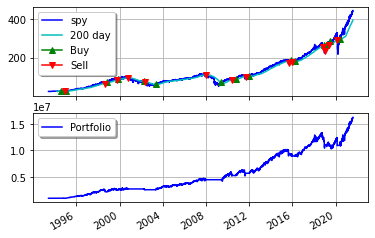

Final portfolio value: $16214465.09
Cumulative returns: 1521.45 %
Max. drawdown: 22.44 %
Longest drawdown duration: 1253 days, 0:00:00

Total trades: 14
Avg. profit: $711643
Profits std. dev.: $1352059
Max. profit: $3541343
Min. profit: $-1449361
Avg. return: 23 %
Returns std. dev.: 37 %
Max. return: 124 %
Min. return: -12 %

Profitable trades: 9
Avg. profit: $1333402
Profits std. dev.: $1267212
Max. profit: $3541343
Min. profit: $158289
Avg. return: 39 %
Returns std. dev.: 38 %
Max. return: 124 %
Min. return:  1 %

Unprofitable trades: 5
Avg. loss: $-407523
Losses std. dev.: $528870
Max. loss: $-1449361
Min. loss: $-411
Avg. return: -4 %
Returns std. dev.:  4 %
Max. return: -0 %
Min. return: -12 %


In [7]:
plt.plot()

print("Final portfolio value: $%.2f" % strategy.getResult())
print("Cumulative returns: %.2f %%" % (returnsAnalyzer.getCumulativeReturns()[-1] * 100))
print("Max. drawdown: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100))
print("Longest drawdown duration: %s" % (drawDownAnalyzer.getLongestDrawDownDuration()))

print("")
print("Total trades: %d" % (tradesAnalyzer.getCount()))
if tradesAnalyzer.getCount() > 0:
    profits = tradesAnalyzer.getAll()
    print("Avg. profit: $%2.f" % (profits.mean()))
    print("Profits std. dev.: $%2.f" % (profits.std()))
    print("Max. profit: $%2.f" % (profits.max()))
    print("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getAllReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))

print("")
print("Profitable trades: %d" % (tradesAnalyzer.getProfitableCount()))
if tradesAnalyzer.getProfitableCount() > 0:
    profits = tradesAnalyzer.getProfits()
    print("Avg. profit: $%2.f" % (profits.mean()))
    print("Profits std. dev.: $%2.f" % (profits.std()))
    print("Max. profit: $%2.f" % (profits.max()))
    print("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getPositiveReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))

print("")
print("Unprofitable trades: %d" % (tradesAnalyzer.getUnprofitableCount()))
if tradesAnalyzer.getUnprofitableCount() > 0:
    losses = tradesAnalyzer.getLosses()
    print("Avg. loss: $%2.f" % (losses.mean()))
    print("Losses std. dev.: $%2.f" % (losses.std()))
    print("Max. loss: $%2.f" % (losses.min()))
    print("Min. loss: $%2.f" % (losses.max()))
    returns = tradesAnalyzer.getNegativeReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))